In [1]:
# ==============================================================================
# Cell 1: Imports
# ==============================================================================
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import seaborn as sns
import os 
import json

# Ensure plots are displayed inline in Jupyter
%matplotlib inline

print("--- Cell 1: Libraries Imported ---")

--- Cell 1: Libraries Imported ---


In [ ]:
## STACK BARS FOR ALL SAMPLES


--- Cell 2: Configuration and File Paths Defined ---
NMF H Matrix Path: /net/users/voy/nmf/koptlib/embryonic_group_nmf_outputs_cli/AllSamples_NMF_K_opt_2_26/25NMF/weights/H_k25.npy
TCGA Z-Scores Path: /net/users/sheddn/TCGA_data/TCGA_zscores.parquet
NMF Component Color Map JSON: nmf_component_color_map.json
Cancer Type Color Map JSON: cancer_type_color_map.json
Vocabulary (Tissue Group) JSON: vocab.json
Embryonic Layer (Emb) JSON: emb.json

--- Cell 3: Loading NMF Sample-by-Component Matrix ---
Successfully loaded H_matrix_data. Shape: (samples=410, components=25)

--- Cell 4: Loading Sample IDs ---
Derived 410 sample IDs. Matches H_matrix_data.

--- Cell 5: Deriving Cancer Type Labels (Short Codes) ---
Derived cancer type short codes for 410 samples.

--- Cell 6: Preparing Data for Visualizations ---
Prepared data for Cancer Type annotation strip (using TCGA codes).
Prepared data for Tissue Group (Vocab 1) annotation strip.
--- Cell 6: Data Preparation Finished ---

--- Cell 8: Gener

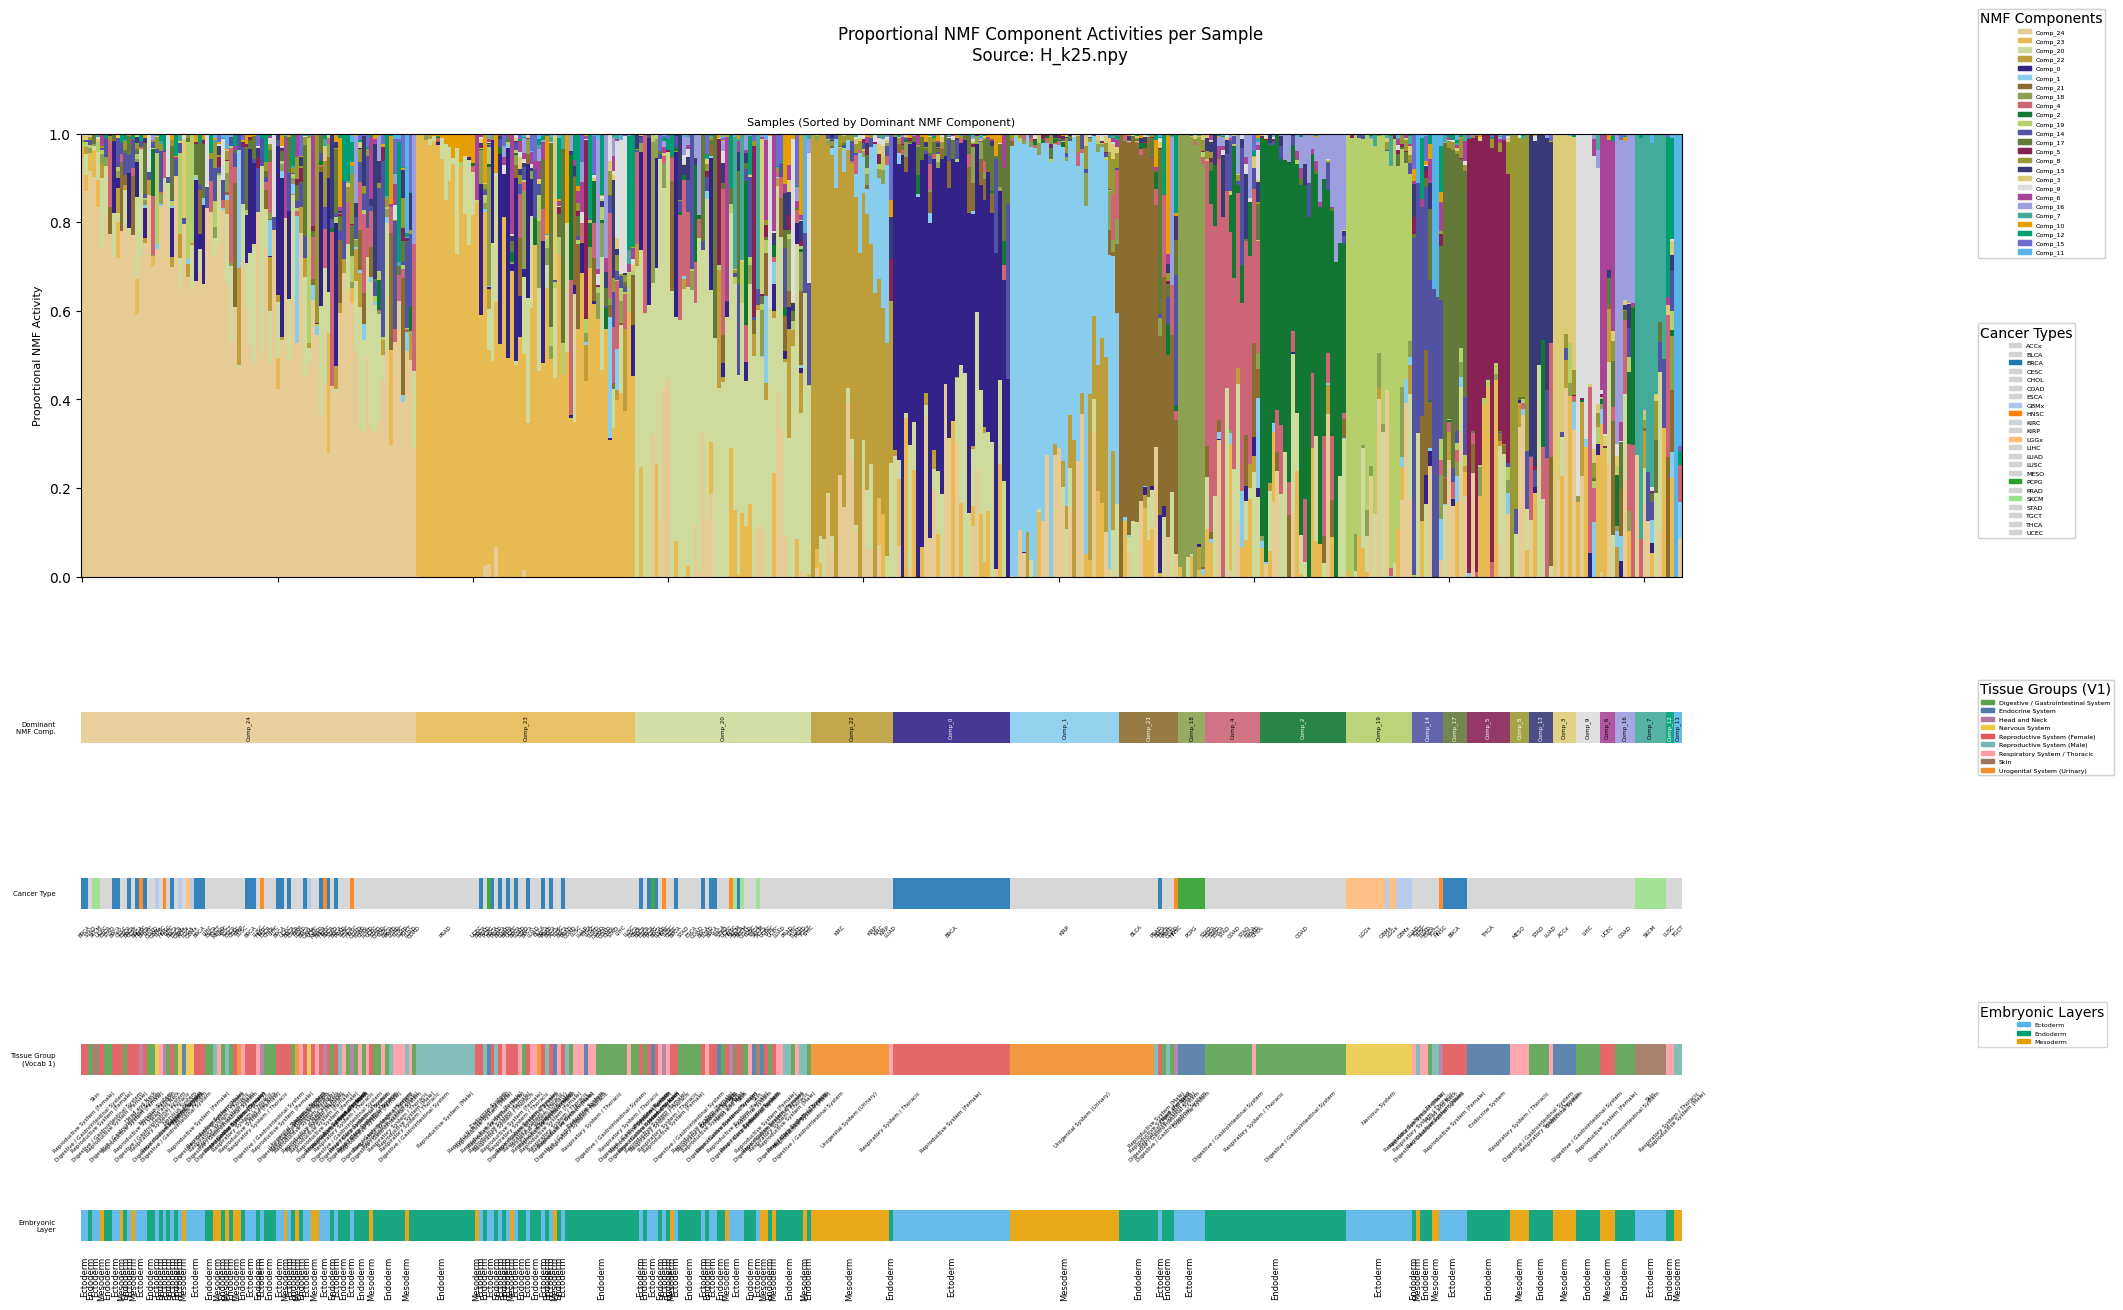


--- Cell 8: Stacked Bar Plot Finished ---


In [31]:
# ==============================================================================
# Cell 2: Configuration and File Paths
# ==============================================================================
# Path to the NMF H matrix (samples x components)
NMF_H_MATRIX_PATH = "/net/users/voy/nmf/koptlib/embryonic_group_nmf_outputs_cli/AllSamples_NMF_K_opt_2_26/25NMF/weights/H_k25.npy"

# Path to the TCGA Z-scores parquet file (for sample IDs)
TCGA_ZSCORES_PATH = "/net/users/sheddn/TCGA_data/TCGA_zscores.parquet"

# JSON file for NMF component colors
JSON_FILENAME_COMPONENT_COLORS = "nmf_component_color_map.json"

# JSON file for the FIRST vocabulary/tissue group strip
JSON_FILENAME_VOCAB = "vocab.json"

# JSON file for the SECOND vocabulary/embryonic layer strip
JSON_FILENAME_EMB = "emb.json" # Corrected filename based on your description

# JSON file for the cancer type color map
JSON_FILENAME_CANCER_TYPE_COLORS = "cancer_type_color_map.json"

# Output plot filename (optional, for saving)
PLOT_FILENAME_STACKED_BAR = "nmf_sample_component_stacked_bar_quad_annotation.png"
CSV_DOMINANT_COMPONENTS = "sample_dominant_nmf_component.csv"


print("\n--- Cell 2: Configuration and File Paths Defined ---")
print(f"NMF H Matrix Path: {NMF_H_MATRIX_PATH}")
print(f"TCGA Z-Scores Path: {TCGA_ZSCORES_PATH}")
print(f"NMF Component Color Map JSON: {JSON_FILENAME_COMPONENT_COLORS}")
print(f"Cancer Type Color Map JSON: {JSON_FILENAME_CANCER_TYPE_COLORS}")
print(f"Vocabulary (Tissue Group) JSON: {JSON_FILENAME_VOCAB}")
print(f"Embryonic Layer (Emb) JSON: {JSON_FILENAME_EMB}")


# ==============================================================================
# Cell 3: Load NMF H Matrix (Sample Activities)
# ==============================================================================
print(f"\n--- Cell 3: Loading NMF Sample-by-Component Matrix ---")
if not os.path.exists(NMF_H_MATRIX_PATH):
    raise FileNotFoundError(f"ERROR: NMF H matrix file not found at '{NMF_H_MATRIX_PATH}'.")
try:
    H_matrix_data = np.load(NMF_H_MATRIX_PATH)
    num_samples, num_components = H_matrix_data.shape
    print(f"Successfully loaded H_matrix_data. Shape: (samples={num_samples}, components={num_components})")
except Exception as e:
    print(f"ERROR loading H_matrix_data: {e}")
    raise

# ==============================================================================
# Cell 4: Load Sample IDs
# ==============================================================================
print(f"\n--- Cell 4: Loading Sample IDs ---")
if not os.path.exists(TCGA_ZSCORES_PATH):
    raise FileNotFoundError(f"ERROR: TCGA Z-scores file not found at '{TCGA_ZSCORES_PATH}'.")
try:
    nmf_sample_ids_list = sorted(pl.scan_parquet(TCGA_ZSCORES_PATH).collect_schema().names()[6:])
    if len(nmf_sample_ids_list) != num_samples:
        raise ValueError("Mismatch between number of sample IDs and H_matrix_data samples.")
    print(f"Derived {len(nmf_sample_ids_list)} sample IDs. Matches H_matrix_data.")
except Exception as e:
    print(f"ERROR deriving sample IDs: {e}")
    raise

# ==============================================================================
# Cell 5: Derive Cancer Type Labels (Short Codes)
# ==============================================================================
print(f"\n--- Cell 5: Deriving Cancer Type Labels (Short Codes) ---")
derived_investigations = [sid.split('-')[0] for sid in nmf_sample_ids_list]
print(f"Derived cancer type short codes for {len(derived_investigations)} samples.")

# ==============================================================================
# Cell 6: Data Preparation for Visualizations
# ==============================================================================
print(f"\n--- Cell 6: Preparing Data for Visualizations ---")

def get_barsortorder(relevantMatrix):
    WinningComponent = np.argmax(relevantMatrix, axis=1)
    barsortorder = np.concatenate([np.argsort(-relevantMatrix[:,i])[WinningComponent[np.argsort(-relevantMatrix[:,i])]==i] for i in range(relevantMatrix.shape[1])])
    return barsortorder.astype(int)

component_total_activity = np.sum(H_matrix_data, axis=0)
programmatic_component_order_indices = np.argsort(-component_total_activity)
H_matrix_ordered_components = H_matrix_data[:, programmatic_component_order_indices]
sample_sort_order = get_barsortorder(H_matrix_ordered_components)
yticklabels_plot = [f"Comp_{idx}" for idx in programmatic_component_order_indices]
sorted_cancer_types_for_plot = np.array(derived_investigations)[sample_sort_order]
winning_component_for_sorted_samples = np.argmax(H_matrix_ordered_components[sample_sort_order, :], axis=1)

def get_tick_positions_and_labels(sorted_labels):
    tick_positions, tick_labels = [], []
    current_label, block_start_idx = None, 0
    for i, label in enumerate(sorted_labels):
        if label != current_label:
            if current_label is not None:
                tick_positions.append(block_start_idx + (i - block_start_idx) / 2 - 0.5)
                tick_labels.append(current_label)
            current_label, block_start_idx = label, i
    tick_positions.append(block_start_idx + (len(sorted_labels) - block_start_idx) / 2 - 0.5)
    tick_labels.append(current_label)
    return tick_positions, tick_labels

tick_positions_cancer, tick_labels_cancer = get_tick_positions_and_labels(sorted_cancer_types_for_plot)
print("Prepared data for Cancer Type annotation strip (using TCGA codes).")

with open(JSON_FILENAME_VOCAB, 'r') as f:
    vocab1_data = json.load(f)
cancer_code_to_vocab1_group_map = {code: g['group_name'] for g in vocab1_data['organ_system_groupings'] for code in g['cancer_codes']}
vocab1_group_to_color_map = {g['group_name']: g['color'] for g in vocab1_data['organ_system_groupings']}
sorted_vocab1_labels = [cancer_code_to_vocab1_group_map.get(c, "Other_V1") for c in sorted_cancer_types_for_plot]
tick_positions_vocab1, tick_labels_vocab1 = get_tick_positions_and_labels(sorted_vocab1_labels)
print("Prepared data for Tissue Group (Vocab 1) annotation strip.")

print("--- Cell 6: Data Preparation Finished ---")

# ==============================================================================
# Cell 8: Stacked Bar Plot with Four Annotation Strips
# ==============================================================================
print(f"\n--- Cell 8: Generating Stacked Bar Plot with Four Annotation Strips ---")

try:
    # Load all color and mapping files
    with open(JSON_FILENAME_COMPONENT_COLORS, 'r') as f: nmf_color_map = json.load(f)
    with open(JSON_FILENAME_CANCER_TYPE_COLORS, 'r') as f: cancer_color_map = json.load(f)
    with open(JSON_FILENAME_EMB, 'r') as f: emb_data = json.load(f)

    # Prepare data for Embryonic Layer strip
    cancer_code_to_emb_group_map = {code: g['group_name'] for g in emb_data['organ_system_groupings'] for code in g['cancer_codes']}
    emb_group_to_color_map = {g['group_name']: g['color'] for g in emb_data['organ_system_groupings']}
    sorted_emb_labels = [cancer_code_to_emb_group_map.get(c, "Other_Emb") for c in sorted_cancer_types_for_plot]
    tick_positions_emb, tick_labels_emb = get_tick_positions_and_labels(sorted_emb_labels)
    print("Prepared data for Embryonic Layer annotation strip.")

    # Prepare data for main plot
    nmf_colors_for_plot = [nmf_color_map.get(comp, '#CCCCCC') for comp in yticklabels_plot]
    H_normalized_proportions_plot = H_matrix_ordered_components[sample_sort_order, :] / (H_matrix_ordered_components[sample_sort_order, :].sum(axis=1, keepdims=True) + 1e-9)

    # --- Plotting Setup ---
    fig = plt.figure(figsize=(max(22, 0.055 * num_samples), 13.5))
    gs = plt.GridSpec(5, 1, height_ratios=[16, 1.1, 1.1, 1.1, 1.1], hspace=1.2)
    ax_main = plt.subplot(gs[0, 0])
    ax_comp = plt.subplot(gs[1, 0], sharex=ax_main)
    ax_cancer = plt.subplot(gs[2, 0], sharex=ax_main)
    ax_vocab = plt.subplot(gs[3, 0], sharex=ax_main)
    ax_emb = plt.subplot(gs[4, 0], sharex=ax_main)

    # --- Main Plot ---
    bottoms = np.zeros(num_samples)
    for i in range(num_components):
        ax_main.bar(np.arange(num_samples), H_normalized_proportions_plot[:, i], bottom=bottoms, label=yticklabels_plot[i], color=nmf_colors_for_plot[i], width=1.0)
        bottoms += H_normalized_proportions_plot[:, i]
    ax_main.set_ylabel("Proportional NMF Activity", fontsize=8)
    ax_main.set_ylim(0, 1)
    ax_main.set_xlim(-0.5, num_samples - 0.5)
    plt.setp(ax_main.get_xticklabels(), visible=False)
    ax_main.set_xlabel("Samples (Sorted by Dominant NMF Component)", fontsize=8, labelpad=6)
    ax_main.xaxis.set_label_position('top')

    # --- Annotation Strips ---
    for ax in [ax_comp, ax_cancer, ax_vocab, ax_emb]:
        ax.set_ylim(0, 1); ax.set_yticks([]); plt.setp(ax.get_xticklabels(), visible=False)
        ax.tick_params(axis='x', length=0)
        for spine in ax.spines.values(): spine.set_visible(False)

    # Strip 1: NMF Component
    current_pos = 0
    for i in range(num_components):
        num_in_block = np.sum(winning_component_for_sorted_samples == i)
        if num_in_block > 0:
            ax_comp.axvspan(current_pos - 0.5, current_pos + num_in_block - 0.5, facecolor=nmf_colors_for_plot[i], alpha=0.9)
            center = current_pos + num_in_block / 2 - 0.5
            text_color = 'white' if np.mean(matplotlib.colors.to_rgb(nmf_colors_for_plot[i])) < 0.5 else 'black'
            ax_comp.text(center, 0.5, yticklabels_plot[i], ha='center', va='center', fontsize=4, rotation=90, color=text_color)
            current_pos += num_in_block
    ax_comp.set_ylabel("Dominant\nNMF Comp.", fontsize=5, rotation=0, ha='right', va='center', labelpad=18)

    # Strip 2: Cancer Type
    for k, cancer_type in enumerate(sorted_cancer_types_for_plot):
        ax_cancer.axvspan(k - 0.5, k + 0.5, facecolor=cancer_color_map.get(cancer_type, "#D3D3D3"), alpha=0.9)
    for pos, label in zip(tick_positions_cancer, tick_labels_cancer):
        ax_cancer.text(pos, -0.5, label, ha='center', va='top', fontsize=4, rotation=45)
    ax_cancer.set_ylabel("Cancer Type", fontsize=5, rotation=0, ha='right', va='center', labelpad=18)

    # Strip 3: Tissue Group
    for k, cancer_code in enumerate(sorted_cancer_types_for_plot):
        group_name = cancer_code_to_vocab1_group_map.get(cancer_code, "Other_V1")
        ax_vocab.axvspan(k - 0.5, k + 0.5, facecolor=vocab1_group_to_color_map.get(group_name, "#A9A9A9"), alpha=0.9)
    for pos, label in zip(tick_positions_vocab1, tick_labels_vocab1):
        ax_vocab.text(pos, -0.5, label, ha='center', va='top', fontsize=4, rotation=45)
    ax_vocab.set_ylabel("Tissue Group\n(Vocab 1)", fontsize=5, rotation=0, ha='right', va='center', labelpad=18)

    # Strip 4: Embryonic Layer (Corrected Logic)
    for k, cancer_code in enumerate(sorted_cancer_types_for_plot):
        group_name = cancer_code_to_emb_group_map.get(cancer_code, "Other_Emb")
        ax_emb.axvspan(k - 0.5, k + 0.5, facecolor=emb_group_to_color_map.get(group_name, "#B0B0B0"), alpha=0.9)
    for pos, label in zip(tick_positions_emb, tick_labels_emb):
        ax_emb.text(pos, -0.5, label, ha='center', va='top', fontsize=6, rotation=90) # Vertical label
    ax_emb.set_ylabel("Embryonic\nLayer", fontsize=5, rotation=0, ha='right', va='center', labelpad=18)

    # --- Legends and Title ---
    legend_handles_nmf = [mpatches.Patch(color=nmf_colors_for_plot[i], label=yticklabels_plot[i]) for i in range(num_components)]
    legend_handles_cancer = [mpatches.Patch(color=cancer_color_map.get(lbl, "#D3D3D3"), label=lbl) for lbl in sorted(list(set(tick_labels_cancer)))]
    legend_handles_vocab1 = [mpatches.Patch(color=vocab1_group_to_color_map.get(lbl, "#A9A9A9"), label=lbl) for lbl in sorted(list(set(tick_labels_vocab1)))]
    legend_handles_emb = [mpatches.Patch(color=emb_group_to_color_map.get(lbl, "#B0B0B0"), label=lbl) for lbl in sorted(list(set(tick_labels_emb)))]

    leg_y_start, leg_y_step, leg_font_size = 0.90, 0.22, 4.5
    
    leg_nmf = fig.legend(handles=legend_handles_nmf, title="NMF Components", loc='center left', bbox_to_anchor=(0.91, leg_y_start), fontsize=leg_font_size)
    leg_y_start -= leg_y_step
    
    leg_cancer = fig.legend(handles=legend_handles_cancer, title="Cancer Types", loc='center left', bbox_to_anchor=(0.91, leg_y_start), fontsize=leg_font_size)
    fig.add_artist(leg_nmf)
    leg_y_start -= leg_y_step
    
    leg_vocab1 = fig.legend(handles=legend_handles_vocab1, title="Tissue Groups (V1)", loc='center left', bbox_to_anchor=(0.91, leg_y_start), fontsize=leg_font_size)
    fig.add_artist(leg_cancer)
    leg_y_start -= leg_y_step

    leg_emb = fig.legend(handles=legend_handles_emb, title="Embryonic Layers", loc='center left', bbox_to_anchor=(0.91, leg_y_start), fontsize=leg_font_size)
    fig.add_artist(leg_vocab1)

    plot_title = f"Proportional NMF Component Activities per Sample\nSource: {os.path.basename(NMF_H_MATRIX_PATH)}"
    fig.suptitle(plot_title, fontsize=12, y=0.98)
    plt.subplots_adjust(left=0.07, right=0.78, bottom=0.08, top=0.90, hspace=1.2)
    
    plt.savefig(PLOT_FILENAME_STACKED_BAR, dpi=300, bbox_inches='tight')
    print(f"\nStacked bar plot saved as '{PLOT_FILENAME_STACKED_BAR}'")
    plt.show()

except Exception as e:
    print(f"An error occurred during stacked bar plot generation: {e}")
    import traceback
    traceback.print_exc()

print(f"\n--- Cell 8: Stacked Bar Plot Finished ---")

In [ ]:
## SUBSET BAR PLOT FOR DOMINANT COMPONENTS
### SUBSETS SHOULD BE DEFINED BELOW, AS "Endoderm", "Mesoderm", "Ectoderm""


--- Cell 3: Loading NMF Sample-by-Component Matrix ---
Successfully loaded H_matrix_data. Shape: (samples=128, components=25)

--- Cell 4: Loading and Reconciling Sample IDs ---
Loaded 410 total possible sample IDs.
SUBSET MODE: Filtering samples for group 'Ectoderm' using 'emb.json'.
Filtered down to 128 samples for group 'Ectoderm'.
Successfully reconciled H matrix with a sample list of 128 IDs.
ASSUMPTION: The rows in the H matrix are sorted alphabetically by sample ID.

--- Cell 5: Deriving Cancer Type Labels (Short Codes) ---
Derived cancer type short codes for 128 samples.

--- Cell 6: Preparing Data for Visualizations ---
Prepared data for Cancer Type annotation strip (using TCGA codes).
Prepared data for Tissue Group (Vocab 1) annotation strip.
--- Cell 6: Data Preparation Finished ---

--- Cell 8: Generating Stacked Bar Plot with Four Annotation Strips ---
Prepared data for Embryonic Layer annotation strip.

Stacked bar plot saved as 'nmf_sample_component_stacked_bar_quad_ann

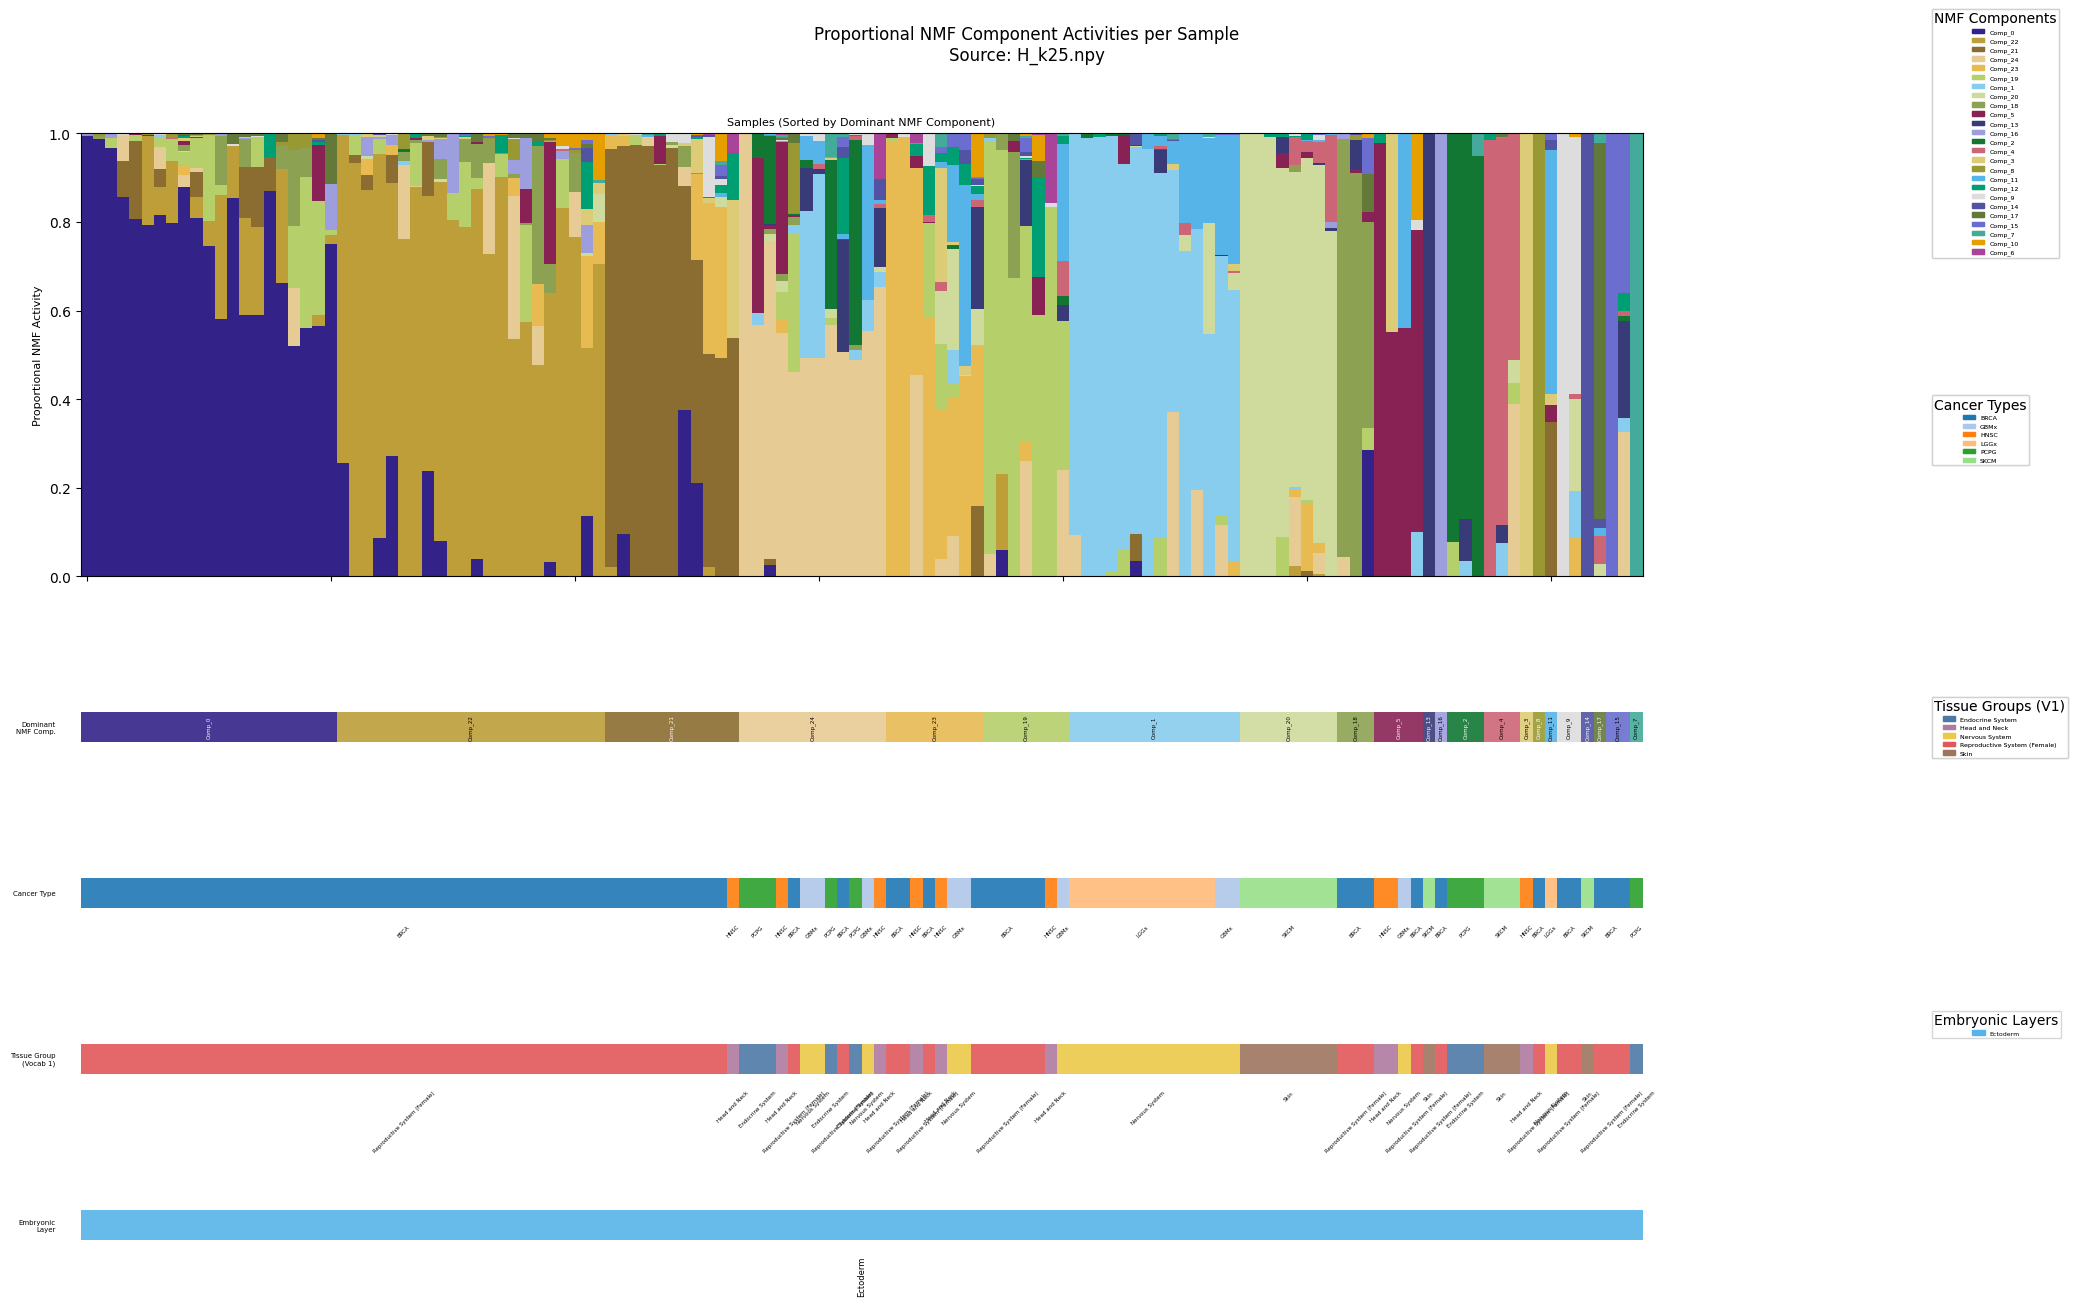


--- Cell 8: Stacked Bar Plot Finished ---


In [32]:
# ==============================================================================
# Cell 2: Configuration and File Paths
# ==============================================================================
# --- REQUIRED: Point this to the H matrix you want to analyze ---
NMF_H_MATRIX_PATH = "/net/users/voy/nmf/koptlib/embryonic_group_nmf_outputs_cli/Ect_NMF_K_opt_2_26/25NMF/weights/H_k25.npy"  # e.g., H_k13_Ectoderm.npy

# --- REQUIRED: Specify which subset this H matrix represents ---
# To run on the full dataset, set this to None.
# To run on a subset, provide the group name defined in the JSON file below.
SUBSET_GROUP = "Ectoderm"  # Options: "Ectoderm", "Mesoderm", "Endoderm", or None
SUBSET_DEFINITION_FILE = "emb.json" # The JSON file that defines the groups

# --- Supporting files ---
TCGA_ZSCORES_PATH = "/net/users/sheddn/TCGA_data/TCGA_zscores.parquet"
JSON_FILENAME_COMPONENT_COLORS = "nmf_component_color_map.json"
JSON_FILENAME_VOCAB = "vocab.json"
JSON_FILENAME_EMB = "emb.json"
JSON_FILENAME_CANCER_TYPE_COLORS = "cancer_type_color_map.json"
PLOT_FILENAME_STACKED_BAR = "nmf_sample_component_stacked_bar_quad_annotation.png"

# ==============================================================================
# Cell 3: Load NMF H Matrix
# ==============================================================================
print(f"\n--- Cell 3: Loading NMF Sample-by-Component Matrix ---")
if not os.path.exists(NMF_H_MATRIX_PATH):
    raise FileNotFoundError(f"ERROR: NMF H matrix file not found at '{NMF_H_MATRIX_PATH}'.")
try:
    H_matrix_data = np.load(NMF_H_MATRIX_PATH)
    num_samples, num_components = H_matrix_data.shape
    print(f"Successfully loaded H_matrix_data. Shape: (samples={num_samples}, components={num_components})")
except Exception as e:
    raise

# ==============================================================================
# Cell 4: Load and Filter Sample List to Match H Matrix
# ==============================================================================
print(f"\n--- Cell 4: Loading and Reconciling Sample IDs ---")
if not os.path.exists(TCGA_ZSCORES_PATH):
    raise FileNotFoundError(f"ERROR: Full sample source file not found at '{TCGA_ZSCORES_PATH}'.")

# First, load the full list of all possible sample IDs
full_sample_ids_list = sorted(pl.scan_parquet(TCGA_ZSCORES_PATH).collect_schema().names()[6:])
print(f"Loaded {len(full_sample_ids_list)} total possible sample IDs.")

if SUBSET_GROUP is None:
    print("No subset specified. Using full dataset.")
    nmf_sample_ids_list = full_sample_ids_list
else:
    print(f"SUBSET MODE: Filtering samples for group '{SUBSET_GROUP}' using '{SUBSET_DEFINITION_FILE}'.")
    with open(SUBSET_DEFINITION_FILE, 'r') as f:
        subset_data = json.load(f)

    target_cancer_codes = {
        code
        for group in subset_data['organ_system_groupings']
        if group['group_name'] == SUBSET_GROUP
        for code in group['cancer_codes']
    }
    if not target_cancer_codes:
        raise ValueError(f"The group '{SUBSET_GROUP}' was not found or has no cancer codes in '{SUBSET_DEFINITION_FILE}'.")

    # Filter the full list down to the samples belonging to the target cancer types
    nmf_sample_ids_list = sorted([
        sid for sid in full_sample_ids_list
        if sid.split('-')[0] in target_cancer_codes
    ])
    print(f"Filtered down to {len(nmf_sample_ids_list)} samples for group '{SUBSET_GROUP}'.")

# CRITICAL VALIDATION: Check if the filtered/full list matches the H matrix shape
if len(nmf_sample_ids_list) != num_samples:
    raise ValueError(
        f"\n\n*** FATAL SHAPE MISMATCH ***\n"
        f"The H matrix has {num_samples} samples.\n"
        f"The filtered sample list for group '{SUBSET_GROUP}' has {len(nmf_sample_ids_list)} samples.\n"
        f"These must match. Please check:\n"
        f"1. Is the SUBSET_GROUP setting in Cell 2 correct for the loaded H matrix?\n"
        f"2. Does your H matrix contain the exact set of samples for this group?\n"
    )

print(f"Successfully reconciled H matrix with a sample list of {len(nmf_sample_ids_list)} IDs.")
print("ASSUMPTION: The rows in the H matrix are sorted alphabetically by sample ID.")

# ==============================================================================
# Cell 5: Derive Cancer Type Labels (Short Codes)
# ==============================================================================
print(f"\n--- Cell 5: Deriving Cancer Type Labels (Short Codes) ---")
derived_investigations = [sid.split('-')[0] for sid in nmf_sample_ids_list]
print(f"Derived cancer type short codes for {len(derived_investigations)} samples.")

# ==============================================================================
# Cell 6: Data Preparation for Visualizations
# ==============================================================================
print(f"\n--- Cell 6: Preparing Data for Visualizations ---")

def get_barsortorder(relevantMatrix):
    WinningComponent = np.argmax(relevantMatrix, axis=1)
    barsortorder = np.concatenate([np.argsort(-relevantMatrix[:,i])[WinningComponent[np.argsort(-relevantMatrix[:,i])]==i] for i in range(relevantMatrix.shape[1])])
    return barsortorder.astype(int)

component_total_activity = np.sum(H_matrix_data, axis=0)
programmatic_component_order_indices = np.argsort(-component_total_activity)
H_matrix_ordered_components = H_matrix_data[:, programmatic_component_order_indices]
sample_sort_order = get_barsortorder(H_matrix_ordered_components)
yticklabels_plot = [f"Comp_{idx}" for idx in programmatic_component_order_indices]
sorted_cancer_types_for_plot = np.array(derived_investigations)[sample_sort_order]
winning_component_for_sorted_samples = np.argmax(H_matrix_ordered_components[sample_sort_order, :], axis=1)

def get_tick_positions_and_labels(sorted_labels):
    tick_positions, tick_labels = [], []
    current_label, block_start_idx = None, 0
    for i, label in enumerate(sorted_labels):
        if label != current_label:
            if current_label is not None:
                tick_positions.append(block_start_idx + (i - block_start_idx) / 2 - 0.5)
                tick_labels.append(current_label)
            current_label, block_start_idx = label, i
    tick_positions.append(block_start_idx + (len(sorted_labels) - block_start_idx) / 2 - 0.5)
    tick_labels.append(current_label)
    return tick_positions, tick_labels

tick_positions_cancer, tick_labels_cancer = get_tick_positions_and_labels(sorted_cancer_types_for_plot)
print("Prepared data for Cancer Type annotation strip (using TCGA codes).")

with open(JSON_FILENAME_VOCAB, 'r') as f:
    vocab1_data = json.load(f)
cancer_code_to_vocab1_group_map = {code: g['group_name'] for g in vocab1_data['organ_system_groupings'] for code in g['cancer_codes']}
vocab1_group_to_color_map = {g['group_name']: g['color'] for g in vocab1_data['organ_system_groupings']}
sorted_vocab1_labels = [cancer_code_to_vocab1_group_map.get(c, "Other_V1") for c in sorted_cancer_types_for_plot]
tick_positions_vocab1, tick_labels_vocab1 = get_tick_positions_and_labels(sorted_vocab1_labels)
print("Prepared data for Tissue Group (Vocab 1) annotation strip.")

print("--- Cell 6: Data Preparation Finished ---")

# ==============================================================================
# Cell 8: Stacked Bar Plot with Four Annotation Strips
# ==============================================================================
print(f"\n--- Cell 8: Generating Stacked Bar Plot with Four Annotation Strips ---")

try:
    # Load all color and mapping files
    with open(JSON_FILENAME_COMPONENT_COLORS, 'r') as f: nmf_color_map = json.load(f)
    with open(JSON_FILENAME_CANCER_TYPE_COLORS, 'r') as f: cancer_color_map = json.load(f)
    with open(JSON_FILENAME_EMB, 'r') as f: emb_data = json.load(f)

    # Prepare data for Embryonic Layer strip
    cancer_code_to_emb_group_map = {code: g['group_name'] for g in emb_data['organ_system_groupings'] for code in g['cancer_codes']}
    emb_group_to_color_map = {g['group_name']: g['color'] for g in emb_data['organ_system_groupings']}
    sorted_emb_labels = [cancer_code_to_emb_group_map.get(c, "Other_Emb") for c in sorted_cancer_types_for_plot]
    tick_positions_emb, tick_labels_emb = get_tick_positions_and_labels(sorted_emb_labels)
    print("Prepared data for Embryonic Layer annotation strip.")

    # Prepare data for main plot
    nmf_colors_for_plot = [nmf_color_map.get(comp, '#CCCCCC') for comp in yticklabels_plot]
    H_normalized_proportions_plot = H_matrix_ordered_components[sample_sort_order, :] / (H_matrix_ordered_components[sample_sort_order, :].sum(axis=1, keepdims=True) + 1e-9)

    # --- Plotting Setup ---
    fig = plt.figure(figsize=(max(22, 0.055 * num_samples), 13.5))
    gs = plt.GridSpec(5, 1, height_ratios=[16, 1.1, 1.1, 1.1, 1.1], hspace=1.2)
    ax_main = plt.subplot(gs[0, 0])
    ax_comp = plt.subplot(gs[1, 0], sharex=ax_main)
    ax_cancer = plt.subplot(gs[2, 0], sharex=ax_main)
    ax_vocab = plt.subplot(gs[3, 0], sharex=ax_main)
    ax_emb = plt.subplot(gs[4, 0], sharex=ax_main)

    # --- Main Plot ---
    bottoms = np.zeros(num_samples)
    for i in range(num_components):
        ax_main.bar(np.arange(num_samples), H_normalized_proportions_plot[:, i], bottom=bottoms, label=yticklabels_plot[i], color=nmf_colors_for_plot[i], width=1.0)
        bottoms += H_normalized_proportions_plot[:, i]
    ax_main.set_ylabel("Proportional NMF Activity", fontsize=8)
    ax_main.set_ylim(0, 1)
    ax_main.set_xlim(-0.5, num_samples - 0.5)
    plt.setp(ax_main.get_xticklabels(), visible=False)
    ax_main.set_xlabel("Samples (Sorted by Dominant NMF Component)", fontsize=8, labelpad=6)
    ax_main.xaxis.set_label_position('top')

    # --- Annotation Strips ---
    for ax in [ax_comp, ax_cancer, ax_vocab, ax_emb]:
        ax.set_ylim(0, 1); ax.set_yticks([]); plt.setp(ax.get_xticklabels(), visible=False)
        ax.tick_params(axis='x', length=0)
        for spine in ax.spines.values(): spine.set_visible(False)

    # Strip 1: NMF Component
    current_pos = 0
    for i in range(num_components):
        num_in_block = np.sum(winning_component_for_sorted_samples == i)
        if num_in_block > 0:
            ax_comp.axvspan(current_pos - 0.5, current_pos + num_in_block - 0.5, facecolor=nmf_colors_for_plot[i], alpha=0.9)
            center = current_pos + num_in_block / 2 - 0.5
            text_color = 'white' if np.mean(matplotlib.colors.to_rgb(nmf_colors_for_plot[i])) < 0.5 else 'black'
            ax_comp.text(center, 0.5, yticklabels_plot[i], ha='center', va='center', fontsize=4, rotation=90, color=text_color)
            current_pos += num_in_block
    ax_comp.set_ylabel("Dominant\nNMF Comp.", fontsize=5, rotation=0, ha='right', va='center', labelpad=18)

    # Strip 2: Cancer Type
    for k, cancer_type in enumerate(sorted_cancer_types_for_plot):
        ax_cancer.axvspan(k - 0.5, k + 0.5, facecolor=cancer_color_map.get(cancer_type, "#D3D3D3"), alpha=0.9)
    for pos, label in zip(tick_positions_cancer, tick_labels_cancer):
        ax_cancer.text(pos, -0.5, label, ha='center', va='top', fontsize=4, rotation=45)
    ax_cancer.set_ylabel("Cancer Type", fontsize=5, rotation=0, ha='right', va='center', labelpad=18)

    # Strip 3: Tissue Group
    for k, cancer_code in enumerate(sorted_cancer_types_for_plot):
        group_name = cancer_code_to_vocab1_group_map.get(cancer_code, "Other_V1")
        ax_vocab.axvspan(k - 0.5, k + 0.5, facecolor=vocab1_group_to_color_map.get(group_name, "#A9A9A9"), alpha=0.9)
    for pos, label in zip(tick_positions_vocab1, tick_labels_vocab1):
        ax_vocab.text(pos, -0.5, label, ha='center', va='top', fontsize=4, rotation=45)
    ax_vocab.set_ylabel("Tissue Group\n(Vocab 1)", fontsize=5, rotation=0, ha='right', va='center', labelpad=18)

    # Strip 4: Embryonic Layer (Corrected Logic)
    for k, cancer_code in enumerate(sorted_cancer_types_for_plot):
        group_name = cancer_code_to_emb_group_map.get(cancer_code, "Other_Emb")
        ax_emb.axvspan(k - 0.5, k + 0.5, facecolor=emb_group_to_color_map.get(group_name, "#B0B0B0"), alpha=0.9)
    for pos, label in zip(tick_positions_emb, tick_labels_emb):
        ax_emb.text(pos, -0.5, label, ha='center', va='top', fontsize=6, rotation=90) # Vertical label
    ax_emb.set_ylabel("Embryonic\nLayer", fontsize=5, rotation=0, ha='right', va='center', labelpad=18)

    # --- Legends and Title ---
    legend_handles_nmf = [mpatches.Patch(color=nmf_colors_for_plot[i], label=yticklabels_plot[i]) for i in range(num_components)]
    legend_handles_cancer = [mpatches.Patch(color=cancer_color_map.get(lbl, "#D3D3D3"), label=lbl) for lbl in sorted(list(set(tick_labels_cancer)))]
    legend_handles_vocab1 = [mpatches.Patch(color=vocab1_group_to_color_map.get(lbl, "#A9A9A9"), label=lbl) for lbl in sorted(list(set(tick_labels_vocab1)))]
    legend_handles_emb = [mpatches.Patch(color=emb_group_to_color_map.get(lbl, "#B0B0B0"), label=lbl) for lbl in sorted(list(set(tick_labels_emb)))]

    leg_y_start, leg_y_step, leg_font_size = 0.90, 0.22, 4.5
    
    leg_nmf = fig.legend(handles=legend_handles_nmf, title="NMF Components", loc='center left', bbox_to_anchor=(0.91, leg_y_start), fontsize=leg_font_size)
    leg_y_start -= leg_y_step
    
    leg_cancer = fig.legend(handles=legend_handles_cancer, title="Cancer Types", loc='center left', bbox_to_anchor=(0.91, leg_y_start), fontsize=leg_font_size)
    fig.add_artist(leg_nmf)
    leg_y_start -= leg_y_step
    
    leg_vocab1 = fig.legend(handles=legend_handles_vocab1, title="Tissue Groups (V1)", loc='center left', bbox_to_anchor=(0.91, leg_y_start), fontsize=leg_font_size)
    fig.add_artist(leg_cancer)
    leg_y_start -= leg_y_step

    leg_emb = fig.legend(handles=legend_handles_emb, title="Embryonic Layers", loc='center left', bbox_to_anchor=(0.91, leg_y_start), fontsize=leg_font_size)
    fig.add_artist(leg_vocab1)

    plot_title = f"Proportional NMF Component Activities per Sample\nSource: {os.path.basename(NMF_H_MATRIX_PATH)}"
    fig.suptitle(plot_title, fontsize=12, y=0.98)
    plt.subplots_adjust(left=0.07, right=0.78, bottom=0.08, top=0.90, hspace=1.2)
    
    plt.savefig(PLOT_FILENAME_STACKED_BAR, dpi=300, bbox_inches='tight')
    print(f"\nStacked bar plot saved as '{PLOT_FILENAME_STACKED_BAR}'")
    plt.show()

except Exception as e:
    print(f"An error occurred during stacked bar plot generation: {e}")
    import traceback
    traceback.print_exc()

print(f"\n--- Cell 8: Stacked Bar Plot Finished ---")
